# Table of Contents
 <p>

In [2]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('apw-notebook')
%matplotlib inline
import h5py

#from __future__ import print_function

from keras.models import Sequential
from keras.layers import Convolution1D, Convolution2D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout, Flatten

Using TensorFlow backend.


In [80]:
# test data
filename_data = "testdata.h5"
dir_data = "data001/"

# sim data
filename_data = "apogee-spectra.h5"
dir_data = "data002/"


In [159]:
dir_base = "/Users/nord/Dropbox/TheCNNon/"
dir_data_full = dir_base + dir_data
file_data = dir_data_full + filename_data

In [227]:
with h5py.File(file_data, 'r') as f:
    X = f['X'][:]#.astype(np.float32)
    y = f['y'][:]#.astype(np.float32)

y = y[:,0:1]
y = y - min(y)
y = y / max(y)
print min(y), max(y)

X[np.isnan(X)] = 0.

[ 0.] [ 1.]


In [267]:
n_train = 512
n_valid = 512
nb_epoch = 1
#n_test = X.shape[0] - n_train - n_valid
n_test = 512
print("Train, Valid, Test", n_train, n_valid, n_test)

('Train, Valid, Test', 512, 512, 512)


In [242]:
X_train = X[:n_train]
y_train = y[:n_train,:1]

X_valid = X[n_train:n_train+n_valid]
y_valid = y[n_train:n_train+n_valid,:1]

X_test = X[n_train+n_valid:]
y_test = y[n_train+n_valid:,:1]
n_objects, n_pixels = X_train.shape
n_objects, n_pixels


(512, 8575)

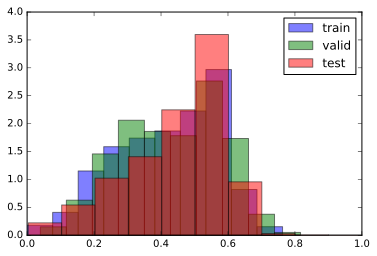

In [243]:
plt.hist(y_train, alpha=0.5, normed=True, label='train');
plt.hist(y_valid, alpha=0.5, normed=True, label='valid');
plt.hist(y_test, alpha=0.5, normed=True, label='test');
plt.legend()

In [268]:
model = Sequential()

model.add(Convolution1D(nb_filter=32, filter_length=256, input_dim=1))
model.add(Activation('sigmoid'))
model.add(MaxPooling1D(pool_length=256))

model.add(Convolution1D(nb_filter=32, filter_length=12))
model.add(Activation('sigmoid'))
model.add(MaxPooling1D(pool_length=12))

# We add a vanilla hidden layer:
# model.add(Dense(128))
# model.add(Dropout(0.5))

model.add(Dense(48))
model.add(Dropout(0.5))
#model.add(Activation('sigmoid'))

model.add(GlobalMaxPooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))

optimizer = 'adadelta'
#optimizer="rmsprop"
model.compile(loss="mse", optimizer=optimizer)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_34 (Convolution1D) (None, None, 32)      8224        convolution1d_input_30[0][0]     
____________________________________________________________________________________________________
activation_55 (Activation)       (None, None, 32)      0           convolution1d_34[0][0]           
____________________________________________________________________________________________________
maxpooling1d_32 (MaxPooling1D)   (None, None, 32)      0           activation_55[0][0]              
____________________________________________________________________________________________________
convolution1d_35 (Convolution1D) (None, None, 32)      12320       maxpooling1d_32[0][0]            
___________________________________________________________________________________________

In [266]:
history = model.fit(X_train.reshape(len(X_train), n_pixels, 1), y_train, nb_epoch=nb_epoch, batch_size=32,
          validation_data=(X_valid.reshape(len(X_valid), n_pixels, 1), y_valid), verbose=True)

Train on 512 samples, validate on 512 samples
Epoch 1/1
512/512 [==============================] - 15s - loss: 0.1992 - val_loss: 0.0226

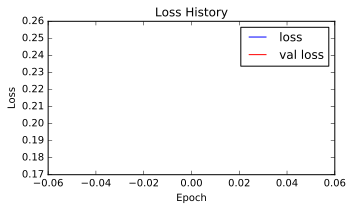

In [246]:
# History
hist = history.history
loss = hist['loss']
val_loss = hist["val_loss"]
epochs = np.arange(nb_epoch)
figsize=(5,3)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="val loss")
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.title("Loss History")
plt.tight_layout()
axis1.legend(loc='upper right')


In [172]:
#score = model.evaluate(X_test.reshape(len(X_test), n_pixels, 1), y_test, batch_size=16)

2048/2048 [==============================] - 100s     

In [262]:
y_pred = model.predict(X_test.reshape(len(X_test), n_pixels, 1), verbose=True)

3072/3072 [==============================] - 33s     

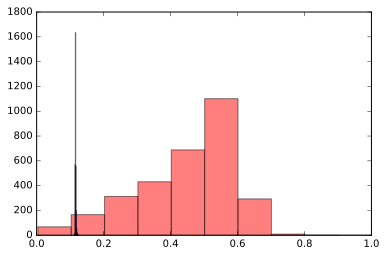

In [263]:
bins =  np.linspace(0.0, 1, 100)
plt.hist(y_test,color='red', alpha=0.5);
plt.hist(y_pred,color='blue', alpha=0.5);

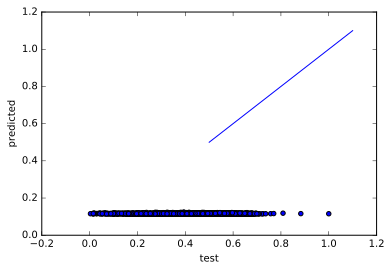

In [264]:
plt.scatter(y_test,y_pred)
xline = yline  = np.linspace(0.5,1.1, 32)
plt.plot(xline,yline)
plt.xlabel('test')
plt.ylabel('predicted')

(array([ 1.,  0.,  0., ...,  6.,  1.,  2.]),
 array([-87.15255124, -87.10692256, -87.06129388, ...,   0.59140616,
          0.63703485,   0.68266353]),
 <a list of 1925 Patch objects>)

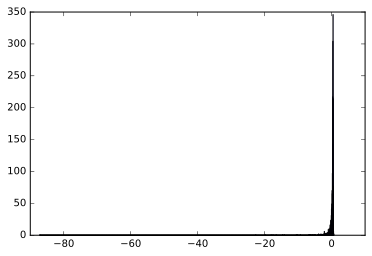

In [206]:
data  =(y_test-y_pred)/y_test#), bins='auto');
#plt.hist(np.log10(np.abs((y_test-y_pred)/y_test)), bins='auto');
plt.hist(data, bins='auto')#, bins=np.logspace(0.1, 1.0, 50))
#plt.gca().set_xscale("log")

In [2]:
"""GAN that learns to generate samples from N(5,1) given N(0,1) noise"""
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py


from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Input
from keras.layers import Convolution1D
from keras.models import Model
from keras.optimizers import Adam
from plotly import tools

## Model parameters
data_dim = 10
noise_dim = 3

## Training parameters
batch_size = 32
num_epochs = 20
num_examples = 10000
num_batches = num_examples / batch_size

## Create generator
# Take as input noise and generate "fake" data
noise_input = Input(shape=(noise_dim,))
x = Dense(16, activation=LeakyReLU(0.1))(noise_input)
generator_output = Dense(output_dim=data_dim)(x)
generator = Model(input=noise_input, output=generator_output)
# Generator loss does not matter, as generator will only be trained through GAN
generator.compile(loss='mse', optimizer='adam')

## Create discriminator
# Take as input data or fake data and output probability of data being real
discriminator_input = Input(shape=(data_dim,))
x = Dense(16, activation=LeakyReLU(0.1))(discriminator_input)
x = Dense(16, activation=LeakyReLU(0.1))(x)
discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Model(input=discriminator_input, output=discriminator_output)
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

## Create Generative Adverserial Network
# The adverserial network is used to train the generator. Take as input noise
# and output probability of data being real. Maximize this.
discriminator.trainable = False # Freeze discriminator weights
gan_input = Input(shape=(noise_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(input=gan_input, output=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=2e-4))

discriminator.trainable = True

## Inputs
data = np.random.normal(5, 1, (num_examples, data_dim))
def sample_noise(mean=0, std=1, shape=(batch_size, noise_dim)):
    return np.random.normal(mean, std, shape)

## Plotting
def plot(data, num_points=256):
    noise_batch = sample_noise(shape=(num_points, noise_dim))
    fake_data_batch = generator.predict(noise_batch)
    data_batch = data[np.random.randint(num_examples, size=num_points)]

    # Plot distributions
    trace_fake = go.Scatter(
        x = fake_data_batch[:,0],
        y = fake_data_batch[:,1],
        mode = 'markers',
        name='Generated Data'
    )

    trace_real = go.Scatter(
        x = data_batch[:,0],
        y = data_batch[:,1],
        mode = 'markers',
        name = 'Real Data'
    )

    data = [trace_fake, trace_real]
    fig = go.Figure(data=data)
    py.plot(fig)

def train_discriminator(data_batch=None):
    """Train D on real or fake data."""
    if data_batch is None: # Train on fake data
        noise_batch = sample_noise()
        fake_data_batch = generator.predict(noise_batch)
        labels = np.zeros(batch_size).astype(int)
        discriminator_loss = \
                discriminator.train_on_batch(fake_data_batch, labels)
    else: # Train on real data
        labels = np.ones(batch_size).astype(int)
        discriminator_loss = \
                discriminator.train_on_batch(data_batch, labels)
    return discriminator_loss

def train_generator():
    """Train the generator."""
    noise_batch = sample_noise()
    # Want to fool discriminator, i.e. make D output 1
    labels = np.ones(batch_size).astype(int)
    gan_loss = gan.train_on_batch(noise_batch, labels)
    return gan_loss

# Pretrain discriminator
shuffled_data = np.random.permutation(data)
for batch in range(num_batches):
    data_batch = shuffled_data[batch * batch_size: (batch + 1) * batch_size]
    train_discriminator()
    train_discriminator(data_batch)

## Training
for epoch in range(num_epochs):

    #if epoch % 2 == 0: plot(data)
    print("\nEpoch {}".format(epoch + 1))
    shuffled_data = np.random.permutation(data)

    for batch in range(num_batches):

        data_batch = shuffled_data[batch * batch_size: (batch + 1) * batch_size]
        discriminator_loss = train_discriminator()
        discriminator_loss = train_discriminator(data_batch)
        gan_loss = train_generator()
        gan_loss = train_generator()

        if batch % 50 == 0:
            print "batch", batch
            print "\t", "gan_loss:", gan_loss, "discriminator_loss", discriminator_loss


Epoch 1
batch 0
	gan_loss: 5.18271 discriminator_loss 0.000868041
batch 50
	gan_loss: 4.82561 discriminator_loss 0.000720812
batch 100
	gan_loss: 4.95705 discriminator_loss 0.00100426
batch 150
	gan_loss: 4.90916 discriminator_loss 0.000520219
batch 200
	gan_loss: 5.27692 discriminator_loss 0.000463912
batch 250
	gan_loss: 5.83043 discriminator_loss 0.0013015
batch 300
	gan_loss: 6.3481 discriminator_loss 0.00207038

Epoch 2
batch 0
	gan_loss: 6.20376 discriminator_loss 0.000939523
batch 50
	gan_loss: 6.63562 discriminator_loss 0.00128807
batch 100
	gan_loss: 6.97197 discriminator_loss 0.00048822
batch 150
	gan_loss: 7.29545 discriminator_loss 0.000506081
batch 200
	gan_loss: 7.66856 discriminator_loss 0.000803401
batch 250
	gan_loss: 7.55168 discriminator_loss 0.0005677
batch 300
	gan_loss: 8.54264 discriminator_loss 0.0204249

Epoch 3
batch 0
	gan_loss: 7.57702 discriminator_loss 0.00258457
batch 50
	gan_loss: 8.92293 discriminator_loss 0.0112267
batch 100
	gan_loss: 8.37167 discrim

Using TensorFlow backend.
